## Introduction to the GLM

Now that the data is clean we can perform analysis. Resting state analysis is completed in notebook 6. This is a review of the general linear model using data that was collected during a breathholding task. 

### Step 1: Ensure you have data from the breath-hold task downloaded to your local machine. 
    
Run the following command in terminal to grab all the fmriprep func data for the sub-10788.

```
# Download unprocessed data
cat download_list |   xargs -I '{}' aws s3 sync --no-sign-request   s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/{}/func   ./data/ds000030/{}/func   --exclude '*'   --include '*sub-10788*' 

# Download anatomical data
cat download_list |   xargs -I '{}' aws s3 sync --no-sign-request   s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/derivatives/fmriprep/{}/anat   ./data/ds000030/derivatives/fmriprep/{}/anat   --exclude '*'   --include '*sub-10788*'

# Download functional data - breath hold task
cat download_list |   xargs -I '{}' aws s3 sync --no-sign-request   s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/derivatives/fmriprep/{}/func   ./data/ds000030/derivatives/fmriprep/{}/func   --exclude '*'   --include '*sub-10788*task-bht_bold*'

```
    
### Step 2: We need to figure out the stimulus for the breath holding task. 

The description of this task is contained in `data/ds000030/task-bht_bold.json`. This does not give precise timing but luckily those are included in the table below:

| Parameter     |  Time (Seconds)      | 
| :-------------: | :-------------: | 
| Rest Time     | 16.5 |
| Activation Time     | 13.5 |
| Block Length     | 30 |
| Scan Time | 150      |
| Repetition Time | 2      |

Now let's use matplotlib to plot the stimulus as a step function.

/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


Text(0.5, 1.0, 'Breath hold activation')

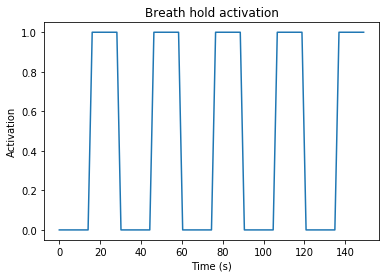

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# make table in python variables
rest_time = 16.5
act_time = 13.5
block_length = act_time+rest_time
scan_time = 150
TR=2
num_blocks = scan_time/block_length

# calculate the time each volume was collected
volume_times = np.linspace(0, scan_time-1, scan_time/TR)
# calulate the stimulus for one block of rest and activation
block_regressor = np.concatenate((np.zeros(int(np.round(rest_time/TR))), np.ones(int(np.round(act_time/TR)))))
#repeat the stimuls for the number of blocks
task_regressor = np.tile(block_regressor, int(num_blocks))

#plot the data
plt.plot(volume_times,task_regressor)
plt.xlabel('Time (s)')
plt.ylabel('Activation')
plt.title('Breath hold activation')

### Step 3: Now that we know what stimulus was used we need to convolve it with a hemodynamic response function. 

The hemodynamic response function (HRF) represents the canconical BOLD response to a delta stimulus. This must be convolved with our task in order to obtain a good activity estimate. This is due to the lag in the increase in CBF and CBV. The canonical HRF can be obtained with the nipy.modalities.fmri.hrf.spmt function. 

Text(0.5, 0, 'Time (s)')

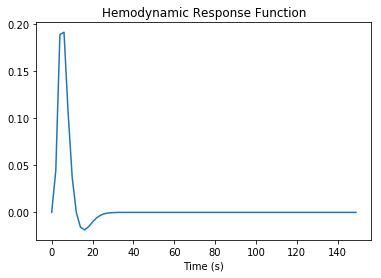

In [8]:
from nipy.modalities.fmri.hrf import spmt

#plot the HRF at the times we are scanning at assuming an impulse at time zero.
hrf = spmt(volume_times)
plt.plot(volume_times, hrf)
plt.title('Hemodynamic Response Function')
plt.xlabel('Time (s)')

This HRF response is in TR just like of `task_regressor`. We can now convolve and plot them using np.convolve(). Convolution represents the task after it is sampled by the HRF as we assume the BOLD response is a linear time invariant system.

Text(0.5, 0, 'Time (s)')

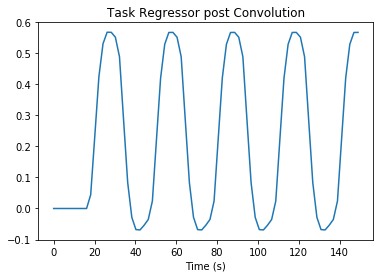

In [11]:
task_convolved = np.convolve(task_regressor, hrf)[0:len(volume_times)]
plt.plot(volume_times,task_convolved)
plt.title('Task Regressor post Convolution')
plt.xlabel('Time (s)')

### Step 4: Now can we fit the fmri data 

In order to determine how much each voxel in the brain was responding to the task we need to perform linear regression between the task response (aka the convolved timeseries) and the data. This regression can be performed a multitude of ways taking into account things like physiology regressors, derivatives, or auto-correlation functions. In the simplest case this regression is just determining how much each voxel responded to the task response and expressing this as $\beta_1$ the mean intensity of that voxel is set to $\beta_0$. 

$Y = \beta_1 X + \beta_0 + \epsilon$

Let's do the simplest example, least squares regression, and look at the results. We want to perform a linear regression between our task response and every voxel's timeseries in our region of interest (aka the brain). First we must load in and mask the data as well as transform it to a 2D array.

In [1]:
import bids

# fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'

layout = bids.BIDSLayout(fmriprep_dir, validate=False)
sub = '10788'

Loaded image shape:  (64, 88, 66, 79)
Masked image shape:  (79, 39076)


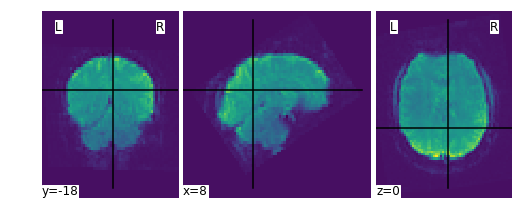

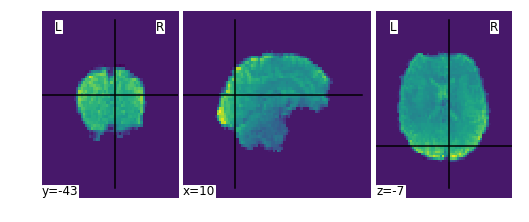

In [15]:
import nibabel as nb
from nilearn import plotting as plot
from nilearn import image as img
from nilearn.input_data import NiftiMasker

mask_filename = layout.get(subject=sub, datatype='func', task='bht', suffix='brainmask', extension='nii.gz')[1]
epi_filename = layout.get(subject=sub, datatype='func', task='bht', suffic='preproc', extension='nii.gz')[1]

epi_data = img.load_img(epi_filename.path)
mask_data = img.load_img(mask_filename.path)

#what shape is this data?
print("Loaded image shape: ",epi_data.shape)

# Let's look at the epi like we did in NB #4
plot.plot_img(epi_data.slicer[:,:,:,0])

# Let's also look at it masked
masked_func = img.math_img('a*b',a=epi_data.slicer[:,:,:,0],b=mask_data)
plot.plot_img(masked_func)

# Use NiftiMasker to mask whole EPI series and transform it into something we can fit
nifti_masker = NiftiMasker(
    smoothing_fwhm=0,
    mask_img=mask_filename,
    memory='nilearn_cache', memory_level=1)

epi_data=nifti_masker.fit_transform(epi_filename)
print("Masked image shape: ", epi_data.shape)

# Now our data is in timepoints by voxels form, lets remove the first four volumes (they are dummy scans)
epi_data = epi_data[4:,:]



We must put our task response and our intercept into a matrix called the design matrix. 

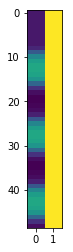

In [19]:
# Our design matrix right now is just our regressor and an offset so our fit is: Y = AX+B+epsilon

X = np.stack((task_convolved, np.ones_like(task_convolved)),axis=1)
plt.figure()
plt.imshow(X[1:50,:], aspect=0.25)



Least squares regression can be performed by np.linalg.lstsq.

In [ ]:
# now we can fit it using a simple least squares regression and map it back to epi space
param_ests, res, _, _=np.linalg.lstsq(X, epi_data)
print("Parameter estimates shape: ", param_ests.shape)

#Let's map this back to image space and plot it
activation_image = nifti_masker.inverse_transform(param_ests[0,:])
plot.plot_img(activation_image, title="Voxel Response", colorbar=True)
mean_val_image = nifti_masker.inverse_transform(param_ests[1,:])
plot.plot_img(mean_val_image,title="Mean Values", colorbar=True)

There are many ways to normalize the voxel responses but we will look at two: percent signal change and the t-statistic.

Percent signal change measures how much the voxel responded relative to the voxel mean and is calulated as shown:

$\% Signal Change=\frac{100\beta_1}{\beta_0}$

t-statistic normalizes the data by the error in the residuals and represents how strong the fit is. It is calulated as shown:

$t-statistic=\frac{\beta_1}{std(\epsilon)}$

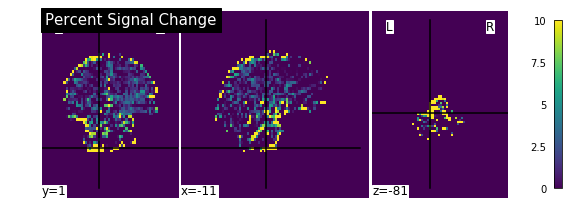

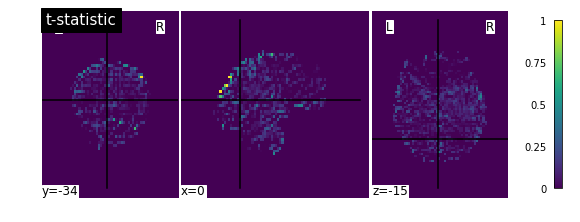

In [21]:
# Let's calculate and plot percent change
percent_change = 100*param_ests[0,:]/param_ests[1,:]
percent_change_image = nifti_masker.inverse_transform(percent_change)
plot.plot_img(percent_change_image, colorbar=True, vmin=0, vmax=10, title="Percent Signal Change")

#Let's caluclate and plot the t-statistic
fit = epi_data - np.dot(X,param_ests)
tstat = param_ests[0,:]/np.std(epi_data-fit)
tstat_image = nifti_masker.inverse_transform(tstat)
plot.plot_img(tstat_image, colorbar=True, vmin=0, vmax=1, title="t-statistic")

### Step 5: Visualizing fit results

Now to visualize the results of our fit on a single voxel level. Lets look at a plot of voxel with the highest t-stat and the fit response as well as the orginal data.

(75, 39076)


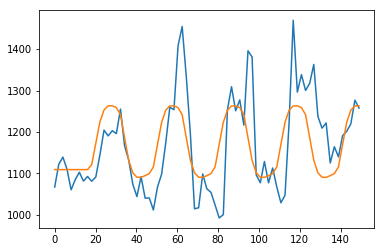

In [23]:
ind = np.argmax(tstat)
print(epi_data.shape)
plt.plot(volume_times, epi_data[:, ind])
plt.plot(volume_times, np.dot(X,param_ests[:,ind]))

We can also look at the residuals across space and time. These can show issues such as motion or physiology contamination.

### Step 6: Improving our fit with confound regressors 

The least squares fit we ran before did not take into account the covariance of our data. 

### Step 7: Wrapping up and Final Thoughts